In [0]:
'''
utils.py
'''
import heapq
from copy import deepcopy
import numpy
from operator import itemgetter

import torch
from torch.utils.model_zoo import tqdm

def hotflip_attack(averaged_grad, embedding_matrix, trigger_token_ids,
                   increase_loss=False, num_candidates=1):
    """
    Borrowed from @Eric-Wallace

    This function takes in the model's average_grad over a batch of examples, the model's
    token embedding matrix, and the current trigger token IDs. It returns the top token
    candidates for each position.

    If increase_loss=True, then the attack reverses the sign of the gradient and tries to increase
    the loss (decrease the model's probability of the true class). For targeted attacks, you want
    to decrease the loss of the target class (increase_loss=False).
    """
    averaged_grad = averaged_grad.cpu()
    embedding_matrix = embedding_matrix.cpu()
    trigger_token_embeds = torch.nn.functional.embedding(torch.LongTensor(trigger_token_ids),
                                                         embedding_matrix).detach().unsqueeze(0)
    averaged_grad = averaged_grad.unsqueeze(0)

    gradient_dot_embedding_matrix = torch.einsum("bij,kj->bik",
                                                 (averaged_grad, embedding_matrix))        
    if not increase_loss:
        gradient_dot_embedding_matrix *= -1    # lower versus increase the class probability.
    if num_candidates > 1: # get top k options
        _, best_k_ids = torch.topk(gradient_dot_embedding_matrix, num_candidates, dim=2)
        return best_k_ids.detach().cpu().numpy()[0]
    _, best_at_each_step = gradient_dot_embedding_matrix.max(2)
    return best_at_each_step[0].detach().cpu().numpy()

def get_best_candidates(model, batch, criterion,trigger_token_ids, cand_trigger_token_ids, device, beam_size=1):
    """"
    Borrowed from @Eric-Wallace

    Given the list of candidate trigger token ids (of number of trigger words by number of candidates
    per word), it finds the best new candidate trigger.
    This performs beam search in a left to right fashion.
    """
    # first round, no beams, just get the loss for each of the candidates in index 0.
    # (indices 1-end are just the old trigger)
    loss_per_candidate = get_loss_per_candidate(0, model, batch, criterion,trigger_token_ids,
                                                cand_trigger_token_ids, device)
    # maximize the loss
    top_candidates = heapq.nlargest(beam_size, loss_per_candidate, key=itemgetter(1))

    # top_candidates now contains beam_size trigger sequences, each with a different 0th token
    for idx in range(1, len(trigger_token_ids)): # for all trigger tokens, skipping the 0th (we did it above)
        loss_per_candidate = []
        for cand, _ in top_candidates: # for all the beams, try all the candidates at idx
            loss_per_candidate.extend(get_loss_per_candidate(idx, model, batch, criterion,cand,
                                                             cand_trigger_token_ids, device))
        top_candidates = heapq.nlargest(beam_size, loss_per_candidate, key=itemgetter(1))
    return max(top_candidates, key=itemgetter(1))[0]

def get_loss_per_candidate(index, model, batch, criterion, trigger_token_ids, cand_trigger_token_ids, device):
    """
    Borrowed from @Eric-Wallace

    For a particular index, the function tries all of the candidate tokens for that index.
    The function returns a list containing the candidate triggers it tried, along with their loss.
    """
    if isinstance(cand_trigger_token_ids[0], (numpy.int64, int)):
        print("Only 1 candidate for index detected, not searching")
        return trigger_token_ids

    loss_per_candidate = []
    # loss for the trigger without trying the candidates
    curr_loss = evaluate_batch_trigger(model, batch, criterion, trigger_token_ids, device)['loss'] \
                    .cpu().detach().numpy()

    loss_per_candidate.append((deepcopy(trigger_token_ids), curr_loss))
    for cand_id in range(len(cand_trigger_token_ids[0])):
        trigger_token_ids_one_replaced = deepcopy(trigger_token_ids) # copy trigger
        trigger_token_ids_one_replaced[index] = cand_trigger_token_ids[index][cand_id] # replace one token

        loss = evaluate_batch_trigger(model, batch, criterion, trigger_token_ids_one_replaced, device)['loss'].cpu().detach().numpy()
        
        # if cand_id in senti_word_id:
        #     loss = 0
        # cand = c_text.vocab.itos[cand_id]
        # for c in cand:
        #     if not c.isalpha():
        #         # print(cand)
        #         loss = 0
        loss_per_candidate.append((deepcopy(trigger_token_ids_one_replaced), loss))

    return loss_per_candidate

################################

def accuracy(y_pred, y_orig):
    y_pred = torch.round(torch.sigmoid(y_pred))
    correct = (y_pred == y_orig).float()
    accuracy = correct.sum() / len(correct)

    return accuracy

def get_accuracy(model, iterator, criterion,trigger_token_ids, device):
    epoch_acc = 0

    print("Finding accuracy...")
    pbar = tqdm(enumerate(iterator), total=len(iterator))
    for _, batch in pbar:
        model.eval()
        res = evaluate_batch_trigger(model, batch, criterion, trigger_token_ids, device)

        epoch_acc += res['acc']
    return epoch_acc / len(iterator)

def evaluate_batch_trigger(model, batch, criterion,trigger_token_ids, device):
    # model.eval()
    text = batch.text
    num_trigger_tokens = len(trigger_token_ids)

    # Append trigger tokens
    with torch.no_grad():
        trigger_sequence_tensor = torch.LongTensor(deepcopy(trigger_token_ids)) # or 2
        trigger_sequence_tensor = trigger_sequence_tensor.repeat(batch.label.shape[0], 1) # batch_size is global
        b_text = torch.cat((trigger_sequence_tensor, text.cpu()), dim=1)
    
        y_pred = model(b_text.cuda()).squeeze(1)
        loss = criterion(y_pred, batch.label.to(device))
        acc = accuracy(y_pred, batch.label.cuda())

    return {'acc': acc, 'loss': loss}

In [0]:
# network.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class Classify_cnn(nn.Module):
    def __init__(self,
                vocab_size, embedding_dim, output_dim,
                num_filters, filter_sizes,
                dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convLayers = nn.ModuleList([
                            nn.Conv2d(1, num_filters, kernel_size = (filter_size, embedding_dim))
                            for filter_size in filter_sizes
        ])

        self.linear = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        '''
        Args:
            text: Size - (batch_size, len(text))
        '''
        embedded = self.embedding(text)   # Size - (batch_size, len(text), embed_dim)
        embedded = embedded.unsqueeze(1)     # Size - (batch_size, 1, len(text), embed_dim)

        convolve = [    
            F.relu(conv(embedded)).squeeze(3)    # Size - (batch_size, num_filters, len(text) - filter_size + 1)
            for conv in self.convLayers    
        ]
        
        pool = [
            F.max_pool1d(conv, conv.shape[2]).squeeze(2) # Size - (batch_size, num_filters)
            for conv in convolve
        ]

        cat = self.dropout(torch.cat(pool, dim=1))  # Size - (batch_size, num_filter * len(filter_sizes)
        return self.linear(cat)

In [3]:
# train.py

import torch
import torch.nn as nn
import torchtext as tt
import torch.optim as optim

from torch.utils.model_zoo import tqdm
import copy
import random
import time

# from utils import *
# from network import RNN

SEED = 1
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device(
            'cuda' if torch.cuda.is_available()
            else 'cpu')


def train_batch(model, batch, optimizer, criterion):
    optimizer.zero_grad()
    text = batch.text
    
    y_pred = model(text).squeeze(1)
    loss = criterion(y_pred, batch.label)
    acc = accuracy(y_pred, batch.label)

    loss.backward()
    optimizer.step()

    return loss.item(), acc.item()

def evaluate_batch(model, batch, criterion):
    with torch.no_grad():
        text = batch.text
    
        y_pred = model(text).squeeze(1)
        loss = criterion(y_pred, batch.label)
        acc = accuracy(y_pred, batch.label)

    return loss.item(), acc.item()

def time_min_sec(s, e):
    diff = e - s
    diff_min = int(diff / 60)
    diff_sec = int(diff - (diff_min * 60))

    return diff_min, diff_sec

extracted_grads = []
def extract_grad_hook(module, grad_in, grad_out):
    extracted_grads.append(grad_out[0])

def preprocess_text(sen):
    # Removing html tags
    TAG_RE = re.compile(r'<[^>]+>')
    def remove_tags(text):
        return TAG_RE.sub('', text)
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

'''
Main function
'''

import re
import spacy
NLP = spacy.load('en')
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)
def tokenizer(sentence):
    # Removing html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return [x.text for x in NLP.tokenizer(sentence) if x.text != " "]

# Include length for packed padded sequence
c_text = tt.data.Field(tokenize=tokenizer, batch_first=True,
                       lower=True)
c_label = tt.data.LabelField(dtype=torch.float)

train_data, test_data = tt.datasets.IMDB.splits(c_text, c_label)
train_data, val_data = train_data.split(random_state=random.seed(SEED))

VOCAB_SIZE = 25000

# Vocab is lookup table for every word
c_text.build_vocab(train_data,
                max_size = VOCAB_SIZE,
                vectors = 'glove.6B.100d',
                unk_init = torch.Tensor.normal_)
c_label.build_vocab(train_data)



batch_size = 64
train_iterator, \
val_iterator, \
test_iterator = tt.data.BucketIterator.splits(
                    (train_data, val_data, test_data),
                    batch_size = batch_size,
                    device = device)

# Initialize model
input_dim = len(c_text.vocab)
embedding_dim = 100 # Should be same as dim of pre trained embeddings
output_dim = 1
num_filters = 100
filter_sizes = [3, 4, 5]
dropout_rate = 0.5
pad_idx = c_text.vocab.stoi[c_text.pad_token]

model = Classify_cnn(input_dim, embedding_dim, output_dim,
                     num_filters, filter_sizes, dropout_rate, pad_idx)

# initialize embeddings
pretrained_embeddings = c_text.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
unk_idx = c_text.vocab.stoi[c_text.unk_token]
model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print("Number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model.to(device)
criterion.to(device)

# Train/Validate loop
EPOCHS = 4
for epoch in range(EPOCHS):
    # Train
    loss, acc = 0, 0
    model.train()
    pbar = tqdm(total=len(train_iterator) + len(val_iterator))
    for batch in train_iterator:
        batch_loss, batch_acc= train_batch(model, batch, optimizer, criterion)
        loss += batch_loss
        acc += batch_acc
        pbar.update(1)
    
    # Validate
    model.eval()
    val_loss, val_acc = 0, 0
    for batch in val_iterator:
        batch_loss, batch_acc= evaluate_batch(model, batch, criterion)
        val_loss += batch_loss
        val_acc += batch_acc
        pbar.update(1)

    loss, acc = loss/len(train_iterator), acc/len(train_iterator)
    val_loss, val_acc = val_loss/len(val_iterator), val_acc/len(val_iterator)

    pbar.set_postfix_str("e: {}/{} => (T/V) Loss: {:.3f} | {:.3f}, Acc: {:.3f} | {:.3f}\n". format(
        epoch, EPOCHS, loss, val_loss, acc*100, val_acc*100))

torch.save(model, 'model.pb')

Number of trainable parameters:  2620801
Classify_cnn(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convLayers): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Classify_cnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


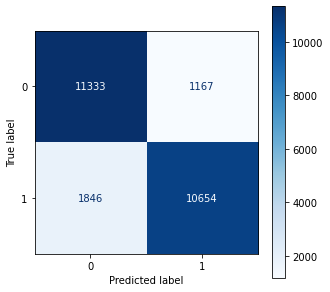

In [4]:
# Test loop
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred = []
orig = []
with torch.no_grad():
    for batch in test_iterator:
        text = batch.text
        y_pred = model(text).squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_pred))

        pred.append(y_pred.cpu())
        orig.append(batch.label.cpu())
        
    pred = torch.cat(pred, dim=0)
    orig = torch.cat(orig, dim=0)
def plot_confusion_matrix(pred_labels, labels):
    
    fig = plt.figure(figsize = (5,5));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, range(2));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plot_confusion_matrix(pred, orig)

# Triggers

In [5]:
# Train 2

'''
Triggers
'''
# Attach hooks for gradients
global extracted_grads
extracted_grads = []
for module in model.modules():
    if isinstance(module, nn.Embedding):
        module.register_backward_hook(extract_grad_hook)

''' Targeted triggers '''
print('TARGETED TRIGGERS')
dataset_label_filter = "pos"
targeted_dev_data = []
for instance in train_data:
    if instance.label == dataset_label_filter:
        targeted_dev_data.append(instance)

target_data = tt.data.Dataset(targeted_dev_data, fields=[('text', c_text), ('label', c_label)])
target_iter = tt.data.Iterator(target_data, batch_size=batch_size, shuffle = True,
                                sort_key=lambda x: x.text[1])

# ''' General Triggers '''
# print("GENERAL TRIGGERS")
# target_iter = test_iterator

# senti_words = []
# f = open("positive-words.txt", "r", encoding = "ISO-8859-1")
# senti_words += [line.rstrip("\n") for line in f.readlines() if line!='\n' and line[0] != ';']
# f = open("negative-words.txt", "r", encoding = "ISO-8859-1")
# senti_words += [line.rstrip("\n") for line in f.readlines() if line!='\n' and line[0] != ';']

# senti_word_id = [c_text.vocab.stoi[word] for word in senti_words]


# Trigger tokens
num_trigger_tokens = 3
trigger_token_ids = [c_text.vocab.stoi["the"]] * num_trigger_tokens

TRIGGER_EPOCHS = 5
for epoch in range(TRIGGER_EPOCHS):
    # Get Accuracy
    print_string = ""
    for idx in trigger_token_ids:
        print_string = print_string + c_text.vocab.itos[idx] + ', '
    print("Current Triggers: " + print_string + " : " + str(get_accuracy(model, target_iter, criterion,trigger_token_ids, device).item()))

    # Get Average grad
    ###
    i = 0
    for batch in target_iter:
        text = batch.text

        optimizer.zero_grad()
        # Reset extracted_grads as in next step we get element at index 0

        # RNN needs to be in train() to calculate gradient
        # Hence, disable dropouts manually
        model.train()
        for name, module in model.named_modules():
            if isinstance(module, nn.Dropout):
                module.p = 0
    
            elif isinstance(module, nn.LSTM):
                module.dropout = 0
    
            elif isinstance(module, nn.GRU):
                module.dropout = 0

        # Append trigger tokens
        trigger_sequence_tensor = torch.LongTensor(copy.deepcopy(trigger_token_ids)) 
        trigger_sequence_tensor = trigger_sequence_tensor.repeat(batch.label.shape[0], 1) # batch_size is global
        b_text = torch.cat((trigger_sequence_tensor, text.cpu()), dim=1)
        

        y_pred = model(b_text.to(device)).squeeze(1)
        loss = criterion(y_pred, batch.label.to(device))

        extracted_grads = []
        loss.backward()
    
        data_grad = extracted_grads[0]
        averaged_grad = torch.sum(data_grad, dim=0)
        # Get gradient of trigger tokens only
        averaged_grad = averaged_grad[0:len(trigger_token_ids)]

        # print(averaged_grad.sum())

        st = time.time()
        cand_trigger_token_ids = hotflip_attack(averaged_grad,
                                                        model.embedding.weight,
                                                        trigger_token_ids,
                                                        num_candidates=40,
                                                        increase_loss=True)
        trigger_token_ids = get_best_candidates(model,
                                                    batch,
                                                    criterion,
                                                    trigger_token_ids,
                                                    cand_trigger_token_ids,
                                                    device)
        et = time.time()

        # if i == 5:
        #     break
        # else:
        #     i += 1
    print("Time spent: ", time_min_sec(st, et))

print_string = ""
for idx in trigger_token_ids:
    print_string = print_string + c_text.vocab.itos[idx] + ', '
print("Current Triggers: " + print_string + " : " + str(get_accuracy(model, target_iter, criterion, trigger_token_ids, device).item()))

TARGETED TRIGGERS
Finding accuracy...



Current Triggers: the, the, the,  : 0.9801240563392639
Time spent:  (0, 1)
Finding accuracy...



Current Triggers: unisol, unisol, rosenlski,  : 0.0
Time spent:  (0, 2)
Finding accuracy...



Current Triggers: unisol, unisol, rosenlski,  : 0.0
Time spent:  (0, 1)
Finding accuracy...



Current Triggers: unisol, unisol, rosenlski,  : 0.0
Time spent:  (0, 1)
Finding accuracy...



Current Triggers: unisol, unisol, rosenlski,  : 0.0
Time spent:  (0, 1)
Finding accuracy...



Current Triggers: unisol, unisol, rosenlski,  : 0.0


# Test User input

In [0]:
import spacy
nlp = spacy.load('en')

def predict_senti(model, sentence):
    model.eval()

    tokenized = [token.text for token in nlp.tokenizer(sentence.lower())]
    indexed = [c_text.vocab.stoi[t] for t in tokenized]

    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)

    y_pred = torch.sigmoid(model(tensor))

    return torch.round(y_pred).item()

def predict_triggered_senti(model, sentence, trigger_tokens):
    model.eval()

    tokenized = trigger_tokens + [token.text for token in nlp.tokenizer(sentence.lower())]
    indexed = [c_text.vocab.stoi[t] for t in tokenized]

    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)

    y_pred = torch.sigmoid(model(tensor))
    return torch.round(y_pred).item()

from IPython.core.display import display, HTML
def html_render(x_orig, x_adv, trig_len):
    x_orig_words = x_orig.split(' ')
    x_adv_words = x_adv.split(' ')
    orig_html = []
    adv_html = []
    # For now, we assume both original and adversarial text have equal lengths.
    for i in range(len(x_orig_words)):
        orig_html.append(x_orig_words[i])

    for i in range(len(x_adv_words)):
        if i < trig_len:
            adv_html.append(format("<b style='color:red'>%s</b>" %x_adv_words[i]))
        else:
            adv_html.append(x_adv_words[i])
    
    orig_html = ' '.join(orig_html)
    adv_html = ' '.join(adv_html)
    return orig_html, adv_html

In [27]:
sentences = [
    'This movies is alright',
    'Pathetic hero. Anyways, the movie is good',
    'Wasted my money on this film',
    'The movie is not good, its amazing',
    'The movie is not good',
    'The movie is bad',
    'Read the book, forget the movie!',
    "This is a good film. This is very funny. Yet after this film there were no good Ernest films!",
]

sentences = [
    "This is a good film. This is very funny. Yet after this film there were no good Ernest films!",
    "Visually imaginative, thematically instructive and thoroughly delightful, it takes us on a roller-coaster ride",
    "As surreal as a dream and as detailed as a photograph, as visually dexterous as it is at times imaginatively overwhelming",
    'Wasted my money on this film',
    'Read the book, forget the movie!',
    'The movie is not good, its amazing',
    'What a terrible film!',
]

trigger_tokens = ['unisol', 'unisol', 'rosenlski']

for sentence in sentences:
    orig, adv = html_render(sentence, " ".join(trigger_tokens) + " " + sentence, len(trigger_tokens))

    print("----------- Original Sentence ----------")
    display(HTML(orig))

    print("----------- Adversarial Sentence ----------")
    display(HTML(adv))
    print("positive" if predict_senti(model, sentence) > 0 else "negative", end=" -> ")
    print("positive" if predict_triggered_senti(model, sentence, trigger_tokens) > 0 else "negative")

    print("="*10)

----------- Original Sentence ----------


----------- Adversarial Sentence ----------


positive -> negative
----------- Original Sentence ----------


----------- Adversarial Sentence ----------


positive -> negative
----------- Original Sentence ----------


----------- Adversarial Sentence ----------


positive -> negative
----------- Original Sentence ----------


----------- Adversarial Sentence ----------


negative -> negative
----------- Original Sentence ----------


----------- Adversarial Sentence ----------


positive -> negative
----------- Original Sentence ----------


----------- Adversarial Sentence ----------


positive -> negative
----------- Original Sentence ----------


----------- Adversarial Sentence ----------


negative -> negative


## Test Accuracy after triggers

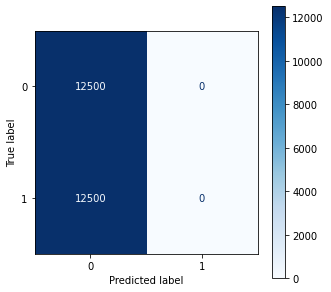

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred = []
orig = []
with torch.no_grad():
    for batch in test_iterator:
        text = batch.text
        trigger_sequence_tensor = torch.LongTensor(copy.deepcopy(trigger_token_ids)) 
        trigger_sequence_tensor = trigger_sequence_tensor.repeat(batch.label.shape[0], 1) # batch_size is global
        b_text = torch.cat((trigger_sequence_tensor, text.cpu()), dim=1)
        

        y_pred = model(b_text.to(device)).squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_pred))

        pred.append(y_pred.cpu())
        orig.append(batch.label.cpu())
        
    pred = torch.cat(pred, dim=0)
    orig = torch.cat(orig, dim=0)
def plot_confusion_matrix(pred_labels, labels):
    
    fig = plt.figure(figsize = (5,5));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, range(2));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plot_confusion_matrix(pred, orig)